# Quantum Linear Systems Problem

## Overview

The quantum linear system problem (QLSP) is a quantum variant of the linear system problem $Ax=b$. Given access to an invertible matrix $A$ and a normalized quantum state $|b\rangle$, QLSP asks for a construction of the solution quantum state
$$ |x\rangle := A^{-1}|b\rangle / ||A^{-1}|b\rangle ||_2 $$
with bounded error.

Suppose the condition number of the coefficient matrix is $\kappa := ||A||_2 / ||A^{-1}||_2$ and $A \in \mathbb{C}^{N \times N}$. There are near-optimal quantum algorithms for solving QLSP with bounded error $\epsilon$ and complexity $\tilde{O}(\kappa \log(1/\epsilon) \text{ polylog}(N))$. In this example, we will deploy a much simpler construction of the solution to QLSP (sacrificing total complexity for pedagogy).

## The equivalent problem in function approximation

The immediate idea for solving QLSP is approximately implementing the map $A \mapsto A^{-1}$. Hence, in light of QSP, the implementation boilds down to a scalar function $f(x) = x^{-1}$. Without loss of generality, we assume the matrix is normalized so that $||A||_2 \leq 1$. Then, the condition number implies that the eigenvalues of $A$ lie in the interval $D_\kappa := [-1,-\kappa]\cup[\kappa, 1]$. We seek to find an odd polynomial approximation to $f(x)$ on the interval $D_\kappa$ so as to exclude the singularity of $f(x)$ at $x=0$.

## Setup

For the sake of this demonstration, we set $\kappa = 10$. To improve the numerical stability of our methods, we scale down the target function by a factor of $1/(2\kappa) = 1/20$ so that
$$ f(x) = \frac{1}{2\kappa x}, \quad \max_{x\in D_\kappa} |f(x)| = \frac{1}{2}. $$

In [1]:
kappa = 10
targ = lambda x: 1/(2*kappa*x)
deg = 151
parity = deg % 2

## Polynomial approximation

To numerically find the best polynomial approximating $f(x)$ on the interval $D_\kappa$, we use a subroutine which solves the problem using convex optimization. We first set the parameters of the subroutine.

In [2]:
import numpy as np

opts = {
    'intervals': [1/kappa, 1],
    'objnorm': np.inf,
    'epsil': 0.01,
    'npts': 500,
    'fscale': 1,
    'isplot': True,
    'method': 'cvxpy'
}

Then, simply calling our subroutine yields the coefficients of the approximation polynomial in the Chebyshev basis. Since the solver outputs all coefficients, we post-select those of odd order due to the parity constraint.

norm error = 1.27808150007791e-07
max of solution = 0.9098806287090062


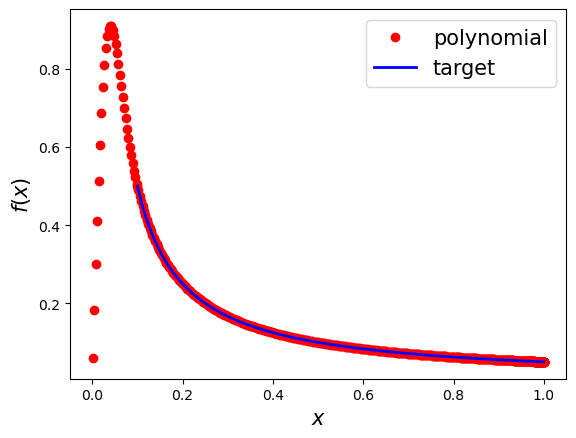

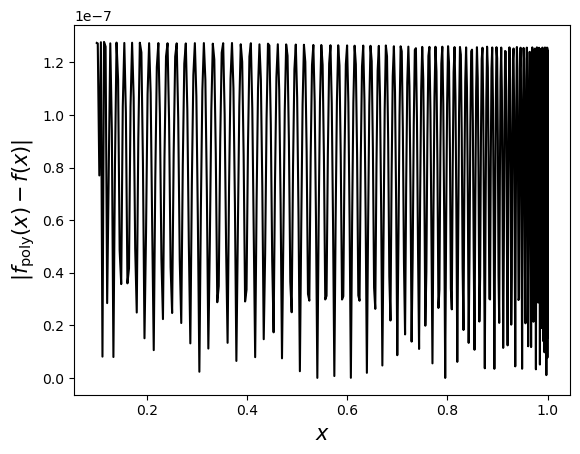

In [3]:
from optimization.utils import cvx_poly_coef

coef_full = cvx_poly_coef(targ, deg, opts)
coef = coef_full[parity::2]

Above we see that both the $\ell_\infty$-error from the optimization scheme and the maximum value of the solution are outputted by `cvx_poly_coef`. The former verifies suitable convergence, the latter verifies that our polynomial satisfies the constraints. Additionally, since `isplot=True`, plots of the polynomial approximation and its error are shown.

## Solving the phase factors for QLSP

We will now initialize the parameters of the solver for finding phase factors using Newton's method.

In [4]:
opts.update({
    'maxiter': 100,
    'criteria': 1e-12,
    'useReal': True,
    'targetPre': True,
    'method': 'Newton'
})

Once these parameters are intialized, we can run the solver.

In [5]:
from optimization.QSP_solver import solve
phi_proc, out = solve(coef, parity, opts)

iter err          
   1  +1.9077e-01
   2  +2.6351e-02
   3  +1.1432e-03
   4  +2.6715e-06
   5  +1.4837e-11
Stop criteria satisfied.


## Verifying the solution

We verify the solved phase factors by computing the residual error in terms of the $\ell_\infty$ norm.

The residual error is
5.329070518200751e-15


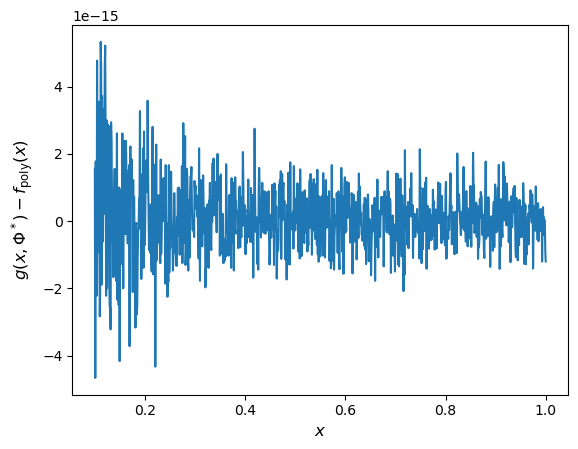

In [6]:
from optimization.utils import chebyshev_to_func
from optimization.core import get_entry
import matplotlib.pyplot as plt

xlist = np.linspace(1/kappa, 1, 1000)
func = lambda x: chebyshev_to_func(x, coef, parity, True)
targ_value = targ(xlist)
func_value = func(xlist)
QSP_value = get_entry(xlist, phi_proc, out)
err = np.linalg.norm(QSP_value - func_value, np.inf)
print('The residual error is')
print(err)

plt.plot(xlist, QSP_value - func_value)
plt.xlabel('$x$', fontsize=12)
plt.ylabel('$g(x,\\Phi^*)-f_\\mathrm{poly}(x)$', fontsize=12)
plt.show()

Note that the residual error above attains almost machine precision.

## Reference

1. Gilyén, A., Su, Y., Low, G. H., & Wiebe, N. (2019, June). Quantum singular value transformation and beyond: exponential improvements for quantum matrix arithmetics. In *Proceedings of the 51st Annual ACM SIGACT Symposium on Theory of Computing* (pp. 193-204).
2. Dong, Y., Meng, X., Whaley, K. B., & Lin, L. (2021). Efficient phase-factor evaluation in quantum signal processing. *Physical Review A*, 103(4), 042419.